# Lab | Logisitc Regression, Handling Imbalanced Data

For this lab we will build a model on customer churn binary classification problem. We will be using the `DATA_Customer-Churn.csv` file.

## Scenario

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.



# 1. Import modules and data

In [34]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Importing the dataframe

In [2]:
def import_dataset():
    return pd.read_csv("DATA_Customer-Churn.txt")

Cleaning function for the dataset. It will do several things:
- column `TotalCharges` is object type. Convert this column into numeric type. 11 of the values are an empty space, we will replace with the monthly charges value.
- Check for null values in the dataframe. Replace the null values. There are no NaN or None values.

In [3]:
def cleaning_df(df):
    mask = df["TotalCharges"] == " " 
    df.loc[mask, "TotalCharges"] = df.loc[mask, "MonthlyCharges"]
    df["TotalCharges"] = df["TotalCharges"].astype(np.float64)
    return df
    

In [4]:
df = import_dataset()
ChurnData = cleaning_df(df)

In [5]:
ChurnData.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# 2. Logistic regression model

Use the following features: `tenure`, `SeniorCitizen`, `MonthlyCharges` and `TotalCharges`:
  - Scale the features either by using normalizer or a standard scaler.
  - Split the data into a training set and a test set.
  - Fit a logistic regression model on the training data.
  - Check the accuracy on the test data.

In [6]:
data = ChurnData[["tenure", "SeniorCitizen", "MonthlyCharges", "TotalCharges"]]
target = ChurnData["Churn"]
data_cols = data.columns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [8]:
scaler = PowerTransformer()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)

In [10]:
score = accuracy_score(y_test, y_pred_test)
print(f"The accuracy on the test data is {score}")

The accuracy on the test data is 0.7898921067575241


Confusion matrix for the test set
[[1195  282]
 [  88  196]]


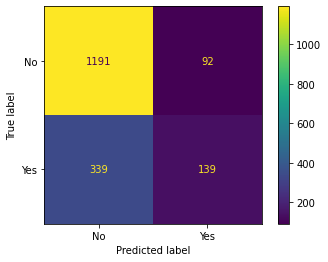

In [11]:
print("Confusion matrix for the test set")
print(confusion_matrix(y_test,y_pred_test).T)
plot_confusion_matrix(logreg,X_test,y_test, values_format = 'd')
plt.show()

# 3. Managing imbalance in the dataset

- Check for the imbalance.
- Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.
- Each time fit the model and see how the accuracy of the model is.

In [12]:
#We will use this function to run the models.
def run_eval_model(X,y):
    """Returns accuracy scaler, logistic regressor, y_pred and y_test"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #Scaling the feature matrix
    transformer = PowerTransformer()
    transformer.fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)
    
    #Creating and running the model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_test = logreg.predict(X_test)
    score = accuracy_score(y_test, y_pred_test)
    print(f"The accuracy on the test data is {score}")
    print("Confusion matrix for the test set")
    print(confusion_matrix(y_test,y_pred_test).T)
    plot_confusion_matrix(logreg, X_test, y_test, values_format = 'd')
    plt.show()
    return score

In [13]:
target.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

There are 1869 positive answers for 5174 negative ones (36%). 

In [14]:
#We will store the scores of each model in a dictionary
scores = {}

### Downsampling: sampling 1869 out of the no churn:

In [15]:
full_data = pd.concat([data, target], axis=1)

In [16]:
category_no = full_data[full_data['Churn'] == "No"]
category_yes = full_data[full_data['Churn'] == "Yes"]

In [17]:
print("No churn - ", category_no.shape[0])
print("Yes churn - ", category_yes.shape[0])

No churn -  5174
Yes churn -  1869


In [18]:
category_no_ds = category_no.sample(len(category_yes))
category_no_ds.shape

(1869, 5)

In [19]:
#We create the new dataset
data_ds = pd.concat([category_no_ds, category_yes], axis=0)
#We shuffle it
data_ds = data_ds.sample(frac=1)

#Separate features and target from the process:
target_ds = data_ds["Churn"]
data_ds = data_ds.drop(columns="Churn")
data_ds.shape


(3738, 4)

Our new dataset has 3738 rows. We run a model with this data and see the results:

The accuracy on the test data is 0.7411764705882353
Confusion matrix for the test set
[[332 116]
 [126 361]]


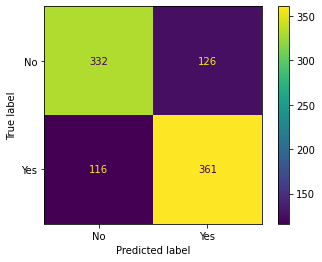

In [20]:
scores["Downsampling"]  = run_eval_model(data_ds, target_ds)

### Upsampling: sampling 5174 times the 1869 positive churns.

In [21]:
category_no = full_data[full_data['Churn'] == "No"]
category_yes = full_data[full_data['Churn'] == "Yes"]

#Sampling
category_yes_us = category_yes.sample(len(category_no), replace=True)

#We create the new dataset
data_us = pd.concat([category_no, category_yes_us], axis=0)
#We shuffle it
data_us = data_us.sample(frac=1)

#Separate features and target from the process:
target_us = data_us["Churn"]
data_us = data_us.drop(columns="Churn")
data_us.shape

(10348, 4)

Our dataset with upsampling has 10348 rows. We run the model and check the results:

The accuracy on the test data is 0.7313490529570932
Confusion matrix for the test set
[[927 343]
 [352 965]]


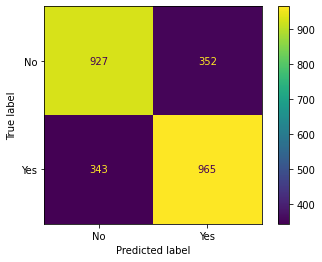

In [22]:
scores["Upsampling"] = run_eval_model(data_us, target_us)

### Other models: SMOTE and TomekLinks

In [23]:
smote = SMOTE()
y = full_data['Churn']
X = full_data.drop(['Churn'], axis=1)
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

The accuracy on the test data is 0.7259373792037108
Confusion matrix for the test set
[[953 317]
 [392 925]]


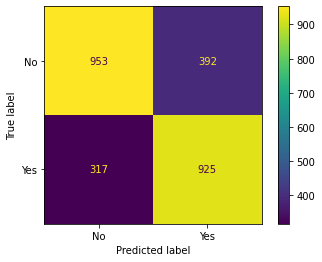

In [24]:
 scores["Smote"] = run_eval_model(X_smote, y_smote)

In [25]:
tomek = TomekLinks('majority')
X_tomek, y_tomek = tomek.fit_resample(X, y)
y_tomek.value_counts()

No     4621
Yes    1869
Name: Churn, dtype: int64

The accuracy on the test data is 0.7954405422057917
Confusion matrix for the test set
[[1033  233]
 [  99  258]]


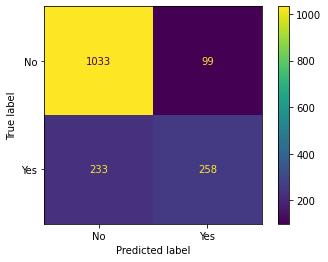

In [26]:
scores["TomekLinks"] = run_eval_model(X_tomek, y_tomek)

### We check the results:

In [27]:
for key, item in scores.items():
    print(f"The score of the {key} method is {item:.3f}.")

The score of the Downsampling method is 0.741.
The score of the Upsampling method is 0.731.
The score of the Smote method is 0.726.
The score of the TomekLinks method is 0.795.


### The TomekLinks system seems to be the best one, followed by the original one, without undersmapling or oversampling.

# 4. Decision Tree exercise

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [31]:
scaler = PowerTransformer()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
tree = DecisionTreeClassifier()
tree.fit(X_train_scaled, y_train)
y_pred_train = tree.predict(X_train_scaled)
y_pred_test = tree.predict(X_test_scaled)

In [42]:
score = accuracy_score(y_test, y_pred_test)
print(f"The accuracy on the test data is {score:.4f}")

The accuracy on the test data is 0.7314


In [37]:
cross_validation_score = cross_val_score(DecisionTreeClassifier(), X_train_scaled, y_train)

In [41]:
print(f"The score with a 5-fold cross validation is {cross_validation_score.mean():.4f}")

The score with a 5-fold cross validation is 0.7145
